In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

2023-09-20 23:12:13.764623: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from tensorflow.keras.preprocessing.image import load_img

In [4]:
load_img


<function keras.utils.image_utils.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest', keep_aspect_ratio=False)>

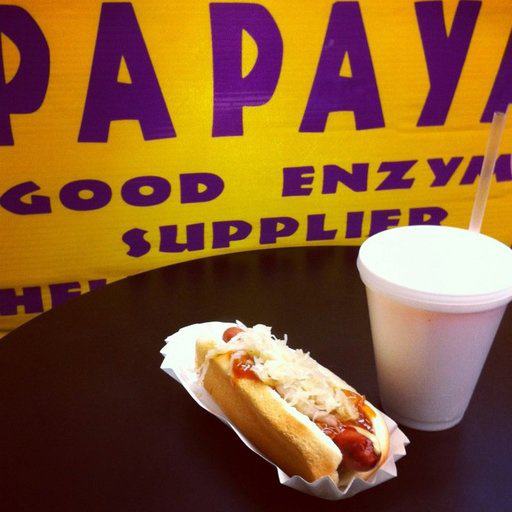

In [5]:
path = './Hotdog-data/train/hot_dog'
name = '1000288.jpg'
fullname = path + '/' + name
load_img(fullname)

In [6]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input 
from tensorflow.keras.applications.xception import decode_predictions

In [7]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

2023-09-20 23:12:19.774734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-20 23:12:19.780982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-20 23:12:19.781591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-20 23:12:19.782520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [8]:
img = load_img(fullname, target_size=(299, 299))

In [9]:
x = np.array(img)
x.shape

(299, 299, 3)

In [10]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [11]:
X = preprocess_input(X)

In [12]:
pred = model.predict(X)

2023-09-20 23:12:23.429561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-09-20 23:12:24.061285: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-20 23:12:24.061818: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-20 23:12:24.061854: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-09-20 23:12:24.062441: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-20 23:12:24.062537: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


In [13]:
pred.shape

(1, 1000)

In [14]:
pred[0, :2]

array([5.93134682e-05, 1.49375155e-05], dtype=float32)

In [15]:
 decode_predictions(pred)

[[('n07697537', 'hotdog', 0.90154284),
  ('n07614500', 'ice_cream', 0.011764896),
  ('n07932039', 'eggnog', 0.0049879644),
  ('n07697313', 'cheeseburger', 0.004458972),
  ('n07753592', 'banana', 0.004071547)]]

### Transfer learning
* Instead of loading each image one-by-one, we can use a data generator ImageDataGenerator. Keras will use it for loading the images and pre-processing them
* Train Xception on smaller (150 x 150)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

image_size = (299, 299)
batch_size = 32

train_ds = train_gen.flow_from_directory(
    "Hotdog-data/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 432 images belonging to 2 classes.


In [18]:
X, y = next(train_ds)
X.shape

(32, 299, 299, 3)

In [19]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
 
  

In [20]:
val_ds = val_gen.flow_from_directory(
    "Hotdog-data/validation",
    target_size=image_size,
    batch_size=batch_size,
     
)

Found 173 images belonging to 2 classes.


In [21]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

base_model.trainable = False

In [22]:
inputs = keras.Input(shape=(299, 299, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(2)(vector)

model = keras.Model(inputs, outputs)

In [23]:
learning_rate = 0.01

optimizer = keras.optimizers.Adam(learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=["accuracy"]
)

In [24]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
14/14 [==============================] - 10s 473ms/step - loss: 0.2698 - accuracy: 0.8750 - val_loss: 0.2444 - val_accuracy: 0.9133
Epoch 2/10
14/14 [==============================] - 4s 312ms/step - loss: 0.1556 - accuracy: 0.9421 - val_loss: 0.3755 - val_accuracy: 0.8902
Epoch 3/10
14/14 [==============================] - 4s 314ms/step - loss: 0.1328 - accuracy: 0.9491 - val_loss: 0.3618 - val_accuracy: 0.8960
Epoch 4/10
14/14 [==============================] - 4s 316ms/step - loss: 0.0896 - accuracy: 0.9630 - val_loss: 0.2329 - val_accuracy: 0.9133
Epoch 5/10
14/14 [==============================] - 5s 320ms/step - loss: 0.0366 - accuracy: 0.9884 - val_loss: 0.2915 - val_accuracy: 0.8960
Epoch 6/10
14/14 [==============================] - 5s 318ms/step - loss: 0.0398 - accuracy: 0.9861 - val_loss: 0.2583 - val_accuracy: 0.8960
Epoch 7/10
14/14 [==============================] - 5s 318ms/step - loss: 0.0194 - accuracy: 0.9954 - val_loss: 0.2424 - val_accuracy: 0.8902
Epoch

In [25]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
14/14 [==============================] - 5s 342ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.2284 - val_accuracy: 0.9075
Epoch 2/10
14/14 [==============================] - 5s 330ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.2400 - val_accuracy: 0.9075
Epoch 3/10
14/14 [==============================] - 5s 330ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.2381 - val_accuracy: 0.9017
Epoch 4/10
14/14 [==============================] - 5s 334ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.2397 - val_accuracy: 0.9075
Epoch 5/10
14/14 [==============================] - 5s 333ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.2367 - val_accuracy: 0.9075
Epoch 6/10
14/14 [==============================] - 5s 336ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.2367 - val_accuracy: 0.9075
Epoch 7/10
14/14 [==============================] - 5s 339ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2337 - val_accuracy: 0.9075
Epoch 

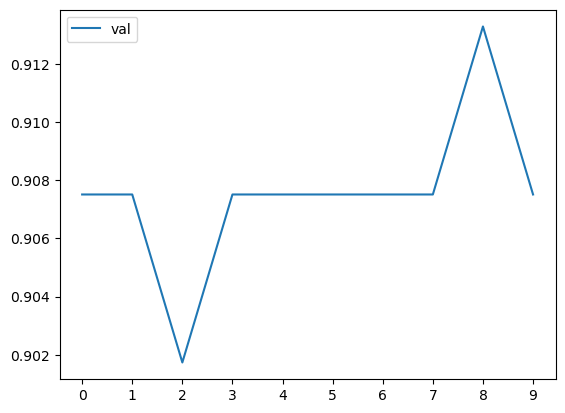

In [26]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Adjusting the learning rate
* What's the learning rate
* Trying different values

In [27]:
def make_model(learning_rate):
    base_model = Xception(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False
    )
    
    base_model.trainable = False 
    
    #########################################
    
    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(2)(vector)
    model = keras.Model(inputs, outputs) 

    #########################################
        
    optimizer = keras.optimizers.Adam(learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )
    
    return model

In [28]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    
    print()
    print()

0.0001
Epoch 1/10
14/14 [==============================] - 8s 416ms/step - loss: 0.5958 - accuracy: 0.7731 - val_loss: 0.6037 - val_accuracy: 0.7457
Epoch 2/10
14/14 [==============================] - 5s 357ms/step - loss: 0.5334 - accuracy: 0.8704 - val_loss: 0.5442 - val_accuracy: 0.7919
Epoch 3/10
14/14 [==============================] - 5s 347ms/step - loss: 0.4823 - accuracy: 0.8981 - val_loss: 0.4977 - val_accuracy: 0.8208
Epoch 4/10
14/14 [==============================] - 5s 339ms/step - loss: 0.4412 - accuracy: 0.9028 - val_loss: 0.4593 - val_accuracy: 0.8208
Epoch 5/10
14/14 [==============================] - 5s 333ms/step - loss: 0.4068 - accuracy: 0.9074 - val_loss: 0.4288 - val_accuracy: 0.8382
Epoch 6/10
14/14 [==============================] - 5s 328ms/step - loss: 0.3787 - accuracy: 0.9144 - val_loss: 0.4021 - val_accuracy: 0.8497
Epoch 7/10
14/14 [==============================] - 5s 327ms/step - loss: 0.3552 - accuracy: 0.9167 - val_loss: 0.3812 - val_accuracy: 0.8613

In [29]:
preds = model.predict(X)

1/1 [==============================] - 1s 628ms/step


In [30]:
del scores[0.0001]

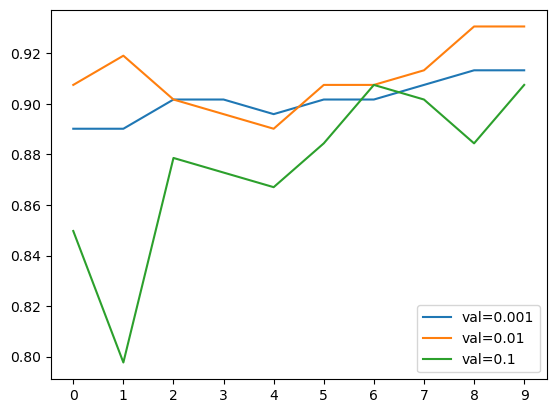

In [31]:
for lr, hist in scores.items():
    
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
    
plt.xticks(np.arange(10))
plt.legend()

#best learning_rate is 0.001

# Checkpointing
* saving the best model only
* Training a model with callbacks

In [32]:
model.save_weights('model_v1.h5', save_format='h5')

In [33]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy",   
)

In [34]:
learning_rate = 0.01

model = make_model(learning_rate=learning_rate)

model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=[checkpoint]
)

Epoch 1/10
14/14 [==============================] - 8s 421ms/step - loss: 0.2773 - accuracy: 0.8866 - val_loss: 0.2466 - val_accuracy: 0.8902
Epoch 2/10
14/14 [==============================] - 5s 343ms/step - loss: 0.1345 - accuracy: 0.9468 - val_loss: 0.2568 - val_accuracy: 0.9133
Epoch 3/10
14/14 [==============================] - 5s 326ms/step - loss: 0.1040 - accuracy: 0.9491 - val_loss: 0.2991 - val_accuracy: 0.9017
Epoch 4/10
14/14 [==============================] - 5s 352ms/step - loss: 0.0825 - accuracy: 0.9699 - val_loss: 0.1937 - val_accuracy: 0.9306
Epoch 5/10
14/14 [==============================] - 5s 328ms/step - loss: 0.0425 - accuracy: 0.9884 - val_loss: 0.2141 - val_accuracy: 0.9017
Epoch 6/10
14/14 [==============================] - 5s 329ms/step - loss: 0.0288 - accuracy: 0.9931 - val_loss: 0.1949 - val_accuracy: 0.9306
Epoch 7/10
14/14 [==============================] - 5s 330ms/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.1894 - val_accuracy: 0.9249
Epoch 

# Adding more layers

In [35]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False
    )
    base_model.trainable = False 
    
    #########################################
    
    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(100, activation='relu')(vector)
    outputs = keras.layers.Dense(2)(inner)
    model = keras.Model(inputs, outputs) 

    #########################################
        
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )
    return model


In [36]:
learning_rate = 0.01

scores = {}  

for size in [10, 100, 1000]:
    print(size)
    
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    
    print()
    print()

10
Epoch 1/10
14/14 [==============================] - 8s 401ms/step - loss: 0.5849 - accuracy: 0.8542 - val_loss: 0.2480 - val_accuracy: 0.8671
Epoch 2/10
14/14 [==============================] - 5s 332ms/step - loss: 0.1514 - accuracy: 0.9491 - val_loss: 0.2660 - val_accuracy: 0.8786
Epoch 3/10
14/14 [==============================] - 5s 335ms/step - loss: 0.0981 - accuracy: 0.9630 - val_loss: 0.2368 - val_accuracy: 0.9017
Epoch 4/10
14/14 [==============================] - 5s 338ms/step - loss: 0.0545 - accuracy: 0.9792 - val_loss: 0.2378 - val_accuracy: 0.9017
Epoch 5/10
14/14 [==============================] - 5s 341ms/step - loss: 0.0316 - accuracy: 0.9954 - val_loss: 0.2613 - val_accuracy: 0.8844
Epoch 6/10
14/14 [==============================] - 5s 345ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.2254 - val_accuracy: 0.9075
Epoch 7/10
14/14 [==============================] - 5s 344ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.2333 - val_accuracy: 0.9191
Epo

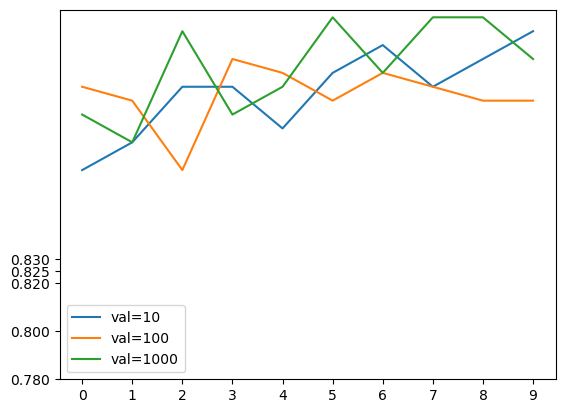

In [37]:
for size, hist in scores.items():
    
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
    
plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

# Regularization and Dropout
* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [38]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False
    )
    base_model.trainable = False 
    
    #########################################
    
    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dense(droprate)(inner)
    outputs = keras.layers.Dense(2)(drop)
    
    model = keras.Model(inputs, outputs) 

    #########################################
        
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=["accuracy"]
    )
    
    return model
 

In [39]:
learning_rate = 0.001
size = 100

scores = {}  

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    
    model = make_model(
        learning_rate=learning_rate, 
        size_inner=size,
        droprate=droprate
    )
    
    history = model.fit(
        train_ds, epochs=30, 
        validation_data=val_ds)
    scores[droprate] = history.history
    
    print()
    print()

0.0
Epoch 1/30
14/14 [==============================] - 8s 419ms/step - loss: 0.6932 - accuracy: 0.4907 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 2/30
14/14 [==============================] - 5s 357ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 3/30
14/14 [==============================] - 5s 357ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 4/30
14/14 [==============================] - 5s 358ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 5/30
14/14 [==============================] - 5s 361ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 6/30
14/14 [==============================] - 5s 361ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 7/30
14/14 [==============================] - 5s 362ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Ep

14/14 [==============================] - 5s 326ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 29/30
14/14 [==============================] - 5s 327ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 30/30
14/14 [==============================] - 5s 328ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087


0.5
Epoch 1/30
14/14 [==============================] - 8s 389ms/step - loss: 0.6932 - accuracy: 0.4907 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 2/30
14/14 [==============================] - 5s 327ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 3/30
14/14 [==============================] - 5s 327ms/step - loss: 0.6932 - accuracy: 0.4861 - val_loss: 0.6932 - val_accuracy: 0.4913
Epoch 4/30
14/14 [==============================] - 5s 328ms/step - loss: 0.6932 - accuracy: 0.4491 - val_loss: 0.6932 - val_accuracy: 0.4913
Epoch 5/3

14/14 [==============================] - 4s 314ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4913
Epoch 26/30
14/14 [==============================] - 4s 312ms/step - loss: 0.6932 - accuracy: 0.4630 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 27/30
14/14 [==============================] - 4s 312ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 28/30
14/14 [==============================] - 4s 314ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 29/30
14/14 [==============================] - 4s 317ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 30/30
14/14 [==============================] - 4s 315ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087




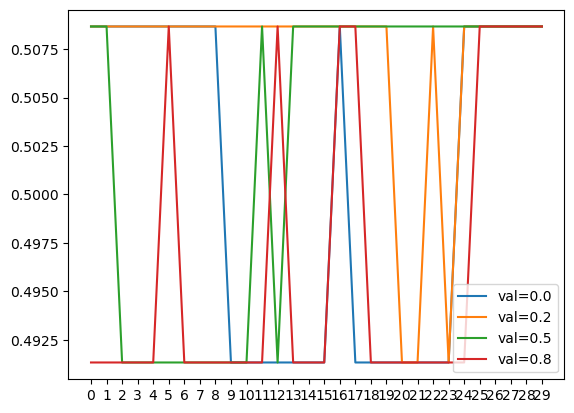

In [40]:
for droprate, hist in scores.items():
    
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
    
plt.xticks(np.arange(30))
plt.legend()

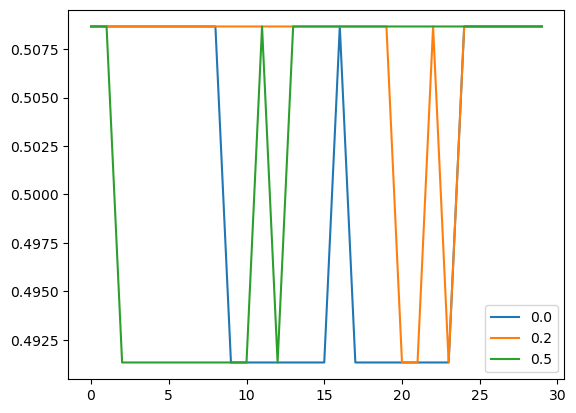

In [41]:
hist = scores[0.0]
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
plt.plot(hist['val_accuracy'], label=0.0)
    
hist = scores[0.2]
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
plt.plot(hist['val_accuracy'], label=0.2)

hist = scores[0.5]
    #plt.plot(hist['accuracy'], label='train=%s' % lr)
plt.plot(hist['val_accuracy'], label=0.5)

plt.legend()

Data Augmentation

In [42]:
train_gen = ImageDataGenerator(
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    "Hotdog-data/train",
    target_size=(299, 299),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    "Hotdog-data/validation",
    target_size=(299, 299),
    batch_size=32
)

Found 432 images belonging to 2 classes.
Found 173 images belonging to 2 classes.


In [43]:
learning_rate = 0.01
size = 100
droprate = 0.2

model = make_model(
        learning_rate=learning_rate, 
        size_inner=size,
        droprate=droprate
)
    
history = model.fit(
        train_ds, epochs=50, 
        validation_data=val_ds) 

Epoch 1/50
14/14 [==============================] - 16s 928ms/step - loss: 0.6940 - accuracy: 0.4815 - val_loss: 0.6930 - val_accuracy: 0.5087
Epoch 2/50
14/14 [==============================] - 12s 825ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 3/50
14/14 [==============================] - 12s 826ms/step - loss: 0.6939 - accuracy: 0.4676 - val_loss: 0.6933 - val_accuracy: 0.4913
Epoch 4/50
14/14 [==============================] - 12s 830ms/step - loss: 0.6937 - accuracy: 0.4676 - val_loss: 0.6930 - val_accuracy: 0.5087
Epoch 5/50
14/14 [==============================] - 12s 828ms/step - loss: 0.6934 - accuracy: 0.4954 - val_loss: 0.6934 - val_accuracy: 0.4913
Epoch 6/50
14/14 [==============================] - 12s 834ms/step - loss: 0.6934 - accuracy: 0.4861 - val_loss: 0.6932 - val_accuracy: 0.4913
Epoch 7/50
14/14 [==============================] - 12s 825ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4913

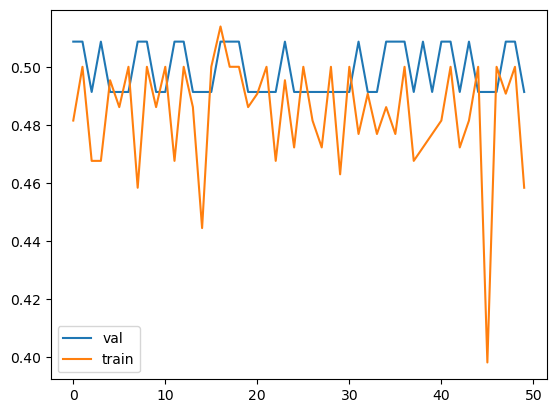

In [44]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
    

plt.legend()

In [45]:
def make_model(input_size=299, learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
    weights='imagenet',
    input_shape=(input_size, input_size, 3),
    include_top=False
    )
    
    base_model.trainable = False 
    
    #########################################
    
    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dense(droprate)(inner)
    outputs = keras.layers.Dense(2)(drop)
    model = keras.Model(inputs, outputs) 

    #########################################
        
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )
    
    return model
 

In [46]:
input_size=299

In [47]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #shear_range=10.0,
    #zoom_range=0.1,
    #horizontal_flip=True 
     
)

train_ds = train_gen.flow_from_directory(
    "Hotdog-data/train",
    target_size=(input_size, input_size),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    "Hotdog-data/validation",
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 432 images belonging to 2 classes.
Found 173 images belonging to 2 classes.


In [48]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode='max'
)

In [49]:
learning_rate = 0.001
size = 100
droprate = 0.2
input_size = 150

model = make_model(
        input_size=150,
        learning_rate=learning_rate, 
        size_inner=size,
        droprate=droprate
)
    
history = model.fit(
        train_ds, epochs=50, 
        validation_data=val_ds, callbacks=[checkpoint])  

Epoch 1/50
14/14 [==============================] - 8s 427ms/step - loss: 0.6933 - accuracy: 0.4676 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 2/50
14/14 [==============================] - 5s 340ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 3/50
14/14 [==============================] - 5s 343ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 4/50
14/14 [==============================] - 5s 342ms/step - loss: 0.6932 - accuracy: 0.4722 - val_loss: 0.6931 - val_accuracy: 0.4913
Epoch 5/50
14/14 [==============================] - 5s 345ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4913
Epoch 6/50
14/14 [==============================] - 5s 346ms/step - loss: 0.6932 - accuracy: 0.4861 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 7/50
14/14 [==============================] - 5s 346ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 

# Using the model
* Loading the model
* Evaluating the model
* Getting the prediction

In [50]:
import tensorflow as tf
from tensorflow import keras

In [51]:
model = keras.models.load_model('xception_v1_09_0.936.h5')

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

In [53]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './Hotdog-data/test', 
    target_size=(299, 299), 
    batch_size=32, 
    shuffle=False
)

Found 393 images belonging to 2 classes.


In [54]:
model.evaluate(test_ds) 

13/13 [==============================] - 4s 278ms/step - loss: 0.1716 - accuracy: 0.9288


[0.17160750925540924, 0.9287531971931458]

In [91]:
path = 'Hotdog-data/test/not_hot_dog/38768.jpg'

In [92]:
img = load_img(path, target_size=(299, 299))

In [93]:
import numpy as np

In [94]:
x = np.array(img)
X = np.array([x])
X.shape  

(1, 299, 299, 3)

In [95]:
X = preprocess_input(X)

In [96]:
pred = model.predict(X)

1/1 [==============================] - 0s 25ms/step


In [97]:
train_ds.class_indices

{'hot_dog': 0, 'not_hot_dog': 1}

In [98]:
classes = [
    'hot_dog',  
    'not_hot_dog'
]

In [90]:
dict(zip(classes, pred[0]))

{'hot_dog': -2.427617, 'not_hot_dog': 2.6227877}